In [1]:
import os
import hydra
import logging
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from sklearn.metrics import f1_score

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.metrics import macro_f1_from_proba
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.experiment.optimization import find_optimal_threshold_for_label, decode_label
from src.experiment.model.custom_metrics import lgb_macro_auc, lgb_macro_f1

In [2]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=018-tabular_v2").split(",")

In [3]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with initialize(version_base=None, config_path="../configs"):
    CFG = compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(CFG)  # use HydraConfig for notebook to use hydra job

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.StreamHandler()
    logger.addHandler(handler)


warnings.filterwarnings("ignore")
INPUT_DIR = Path(CFG.paths.input_dir)
OUTPUT_DIR = Path(CFG.paths.output_dir)

### Load Data


In [4]:
def assign_meta(df: pd.DataFrame, data="train"):
    df["data"] = data
    df["fold"] = -1
    return df


def align_train_test_unique(train, test, ignore_columns=["uid", "data", "fold", "created_at"], fill_value=np.nan):
    """
    This function modifies both 'train' and 'test' DataFrames. For each column,
    it replaces values that are unique to either set (not common to both) with NaN.

    :param train: DataFrame used for training.
    :param test: DataFrame used for testing.
    :return: Tuple of modified train and test DataFrames.
    """
    aligned_train = train.copy()
    aligned_test = test.copy()

    for column in train.columns:
        if column in ignore_columns:
            continue
        if column in test.columns:
            # Find values that are not common to both train and test sets
            common_values = set(train[column]).intersection(set(test[column]))

            aligned_train[column] = train[column].apply(lambda x: x if x in common_values else fill_value)
            aligned_test[column] = test[column].apply(lambda x: x if x in common_values else fill_value)

    return aligned_train, aligned_test


def replace_rare_values(df, cols, threshold, replacement_value):
    """
    This function replaces values in each column of the DataFrame that appear less frequently
    than the specified threshold with a specified replacement value.

    :param df: DataFrame to process.
    :param threshold: Frequency threshold. Values appearing less than this will be replaced.
    :param replacement_value: The value to replace rare values with.
    :return: Modified DataFrame.
    """
    for column in cols:
        value_counts = df[column].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index

        df[column] = df[column].apply(lambda x: replacement_value if x in values_to_replace else x)
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = pd.read_csv(INPUT_DIR / "test.csv").rename(columns={"Unnamed: 0": "uid"})
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(train_df, data="train")
test_df = assign_meta(test_df, data="test")

if CFG.align_train_test:
    train_df, test_df = align_train_test_unique(
        train=train_df,
        test=test_df,
        ignore_columns=[
            "uid",
            "data",
            "fold",
            "created_at",
            "tree_dbh",
            # "spc_common",
            # "spc_latin",
        ],
    )  #  test にないものは nan にする

for col in test_df.columns:
    if test_df[col].dtype == "float":
        continue
    logger.info(f"{col}: {train_df[col].nunique()}, {test_df[col].nunique()}")

uid: 19984, 19702
created_at: 447, 447
tree_dbh: 42, 44
curb_loc: 2, 2
steward: 3, 3
guards: 3, 3
sidewalk: 2, 2
user_type: 3, 3
problems: 73, 73
spc_common: 118, 118
spc_latin: 118, 118
nta: 184, 184
nta_name: 184, 184
borocode: 5, 5
boro_ct: 971, 971
boroname: 5, 5
zip_city: 45, 45
cb_num: 59, 59
st_senate: 26, 26
st_assem: 65, 65
cncldist: 51, 51
data: 1, 1
fold: 1, 1


### CV Split


In [5]:
kfold = hydra.utils.instantiate(CFG.cv)
train_df = assign_fold_index(train_df=train_df, kfold=kfold, y_col="health")

raw_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

if CFG.replace_rare_values_threshold is not None:
    raw_df = replace_rare_values(
        df=raw_df,
        cols=[
            "spc_common",
            "spc_latin",
            "boro_ct",
            "cb_num",
            "st_assem",
            "nta",
            "nta_name",
            "zip_city",
            "borocode",
            "boroname",
            "st_senate",
            "cncldist",
        ],
        threshold=CFG.replace_rare_values_threshold,
        replacement_value=np.nan,
    )

    for col in raw_df.columns:
        logger.info(f"{col}: {raw_df[col].nunique()}")

uid: 39686
created_at: 447
tree_dbh: 44
curb_loc: 2
health: 3
steward: 3
guards: 3
sidewalk: 2
user_type: 3
problems: 73
spc_common: 34
spc_latin: 34
nta: 142
nta_name: 142
borocode: 5
boro_ct: 49
boroname: 5
zip_city: 40
cb_num: 58
st_senate: 26
st_assem: 65
cncldist: 51
data: 2
fold: 6


### Feature Engineering


In [6]:
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)

for extractor in CFG.agg_feature_extractors:
    if CFG.group_keys_for_agg is not None:
        for group_keys in CFG.group_keys_for_agg:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

for extractor in CFG.te_feature_extractors:
    if CFG.group_keys_for_te is not None:
        for group_keys in CFG.group_keys_for_te:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

raw_feature_df = run_extractors(
    input_df=raw_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=True,
    cache=CFG.cache_feature_extractors,
)
assert len(raw_df) == len(raw_feature_df)

raw_feature_df = pd.concat([raw_df, raw_feature_df], axis=1)
train_feature_df = raw_feature_df.query("data == 'train'").reset_index(drop=True).astype({"health": int})
test_feature_df = raw_feature_df.query("data == 'test'").reset_index(drop=True)

feature_columns = [col for col in train_feature_df.columns if col.startswith("f_")]
logger.info(f"num features: {len(feature_columns)}")

<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<CurbLocationFeatureExtractorV1_ffb6a02e825b9d360512f969787b1224531b252c126bdfe37bcd16e4bc25f9e8>
<StreetWidthFeatureExtractorV1_e1934d345bbdbad6b6f154ab09d29008992672b28417152d8b0cc4d67cf97d52>
<GuardsFeatureExtractorV1_32effaf7c5b3c0140641140dbe7f670e6864cab220e3ce069c29ba661bbb756d>
<SidewalkFeatureExtractorV1_11ff165eda5af11f1928f4588c36bd9dd7a3197cf1f18f4f1d741ebc6292d04e>
<UserTypeFeatureExtractorV1_807ed6f844d318d70e501ed5fcef4e2324682fd3d8bd67d9ce65f98c8fd9468f>
<ProblemsFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<RawTransformer_c4f01b5edb85ce7283293fd3521ec16ee558910166a42954cf7e8e9944cfed21>
<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<TreeDbhFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<SpcCommonFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4

### Train


In [7]:
def assign_seed_average_pred(result_df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in result_df.columns if col.startswith("pred_")]
    pred = 0
    for col in cols:
        pred += np.array(result_df[col].tolist())
    result_df["pred"] = list(pred / len(cols))
    return result_df.reset_index()


valid_result_df = pd.DataFrame()
all_trained_estimators = []
for seed in CFG.seed_average_seeds:
    logger.info(f"\n\nstart training seed={seed} 🚀")
    CFG.model.estimator.random_state = seed

    if CFG.use_cat_features:
        cat_features = [x for x in feature_columns if x.startswith("f_oe_")]
        estimator = hydra.utils.instantiate(CFG.model.estimator, cat_features=cat_features)
    else:
        estimator = hydra.utils.instantiate(CFG.model.estimator)

    fit_params = dict(hydra.utils.instantiate(CFG.model.fit_params))
    if estimator.__class__.__name__.startswith("LGBM"):
        fit_params["eval_metric"] = [
            lgb_macro_f1,
            # lgb_macro_auc,
        ]

    model_output_dir = OUTPUT_DIR / "models" / f"seed{seed}"
    trained_estimators = train_cv_tabular_v1(
        df=train_feature_df,
        estimator=estimator,
        feature_columns=feature_columns,
        target_columns=["health"],
        fit_params=fit_params,
        output_dir=model_output_dir,
        overwrite=CFG.overwrite_training,
    )

    i_valid_result_df = predict_cv_tabular_v1(
        df=train_feature_df,
        estimators=trained_estimators,
        feature_columns=feature_columns,
        predict_proba=CFG.model.predict_proba,
    )
    val_score = macro_f1_from_proba(
        y_true=i_valid_result_df["health"],
        y_pred=i_valid_result_df["pred"].tolist(),
    )
    logger.info(f"macro f1 score [seed={seed}]: {val_score}")

    valid_result_df = pd.concat(
        [
            valid_result_df,
            i_valid_result_df[["uid", "pred", "health"]]
            .set_index(["uid", "health"])
            .rename(columns={"pred": f"pred_{seed}"}),
        ],
        axis=1,
    )
    all_trained_estimators.extend(trained_estimators)


valid_result_df = assign_seed_average_pred(valid_result_df)
val_proba = np.array(valid_result_df["pred"].tolist())
val_score = macro_f1_from_proba(y_true=valid_result_df["health"], y_pred=val_proba)

opt_results, val_pred_label = find_optimal_threshold_for_label(
    proba_matrix=val_proba,
    true_labels=valid_result_df["health"],
    label_indices=[2, 0, 1],
)
best_f1_score = f1_score(
    y_true=valid_result_df["health"],
    y_pred=val_pred_label,
    average="macro",
)

logger.info(f"macro f1 score: {val_score}")
logger.info(f"optimized thresholds: {opt_results}")
logger.info(f"best f1 score: {best_f1_score}")

joblib.dump(valid_result_df[["uid", "health", "pred"]], OUTPUT_DIR / "valid_result_df.pkl")



start training seed=8823 🚀
start training fold=0 🚀 
estimator : LGBMModel_b5f55fa88d8ebdb4f5ddfd2f9b044d40acbd4b066dc43eff0b924744902d8e12


[LightGBM] [Info] Total Bins 21538
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 869
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.949516	valid_0's macro_f1: 0.354669
[200]	valid_0's multi_logloss: 0.875396	valid_0's macro_f1: 0.372218
[300]	valid_0's multi_logloss: 0.821134	valid_0's macro_f1: 0.379058
[400]	valid_0's multi_logloss: 0.780306	valid_0's macro_f1: 0.382395


start training fold=1 🚀 


Early stopping, best iteration is:
[358]	valid_0's multi_logloss: 0.795389	valid_0's macro_f1: 0.391421


estimator : LGBMModel_b5f55fa88d8ebdb4f5ddfd2f9b044d40acbd4b066dc43eff0b924744902d8e12


[LightGBM] [Info] Total Bins 21538
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 869
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.973323	valid_0's macro_f1: 0.33786
[200]	valid_0's multi_logloss: 0.900976	valid_0's macro_f1: 0.354957
[300]	valid_0's multi_logloss: 0.845782	valid_0's macro_f1: 0.370769
[400]	valid_0's multi_logloss: 0.805359	valid_0's macro_f1: 0.37135
[500]	valid_0's multi_logloss: 0.771449	valid_0's macro_f1: 0.375162
[600]	valid_0's multi_logloss: 0.748904	valid_0's macro_f1: 0.37397


start training fold=2 🚀 


Early stopping, best iteration is:
[564]	valid_0's multi_logloss: 0.756015	valid_0's macro_f1: 0.383176


estimator : LGBMModel_b5f55fa88d8ebdb4f5ddfd2f9b044d40acbd4b066dc43eff0b924744902d8e12


[LightGBM] [Info] Total Bins 21509
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 869
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.950506	valid_0's macro_f1: 0.354038
[200]	valid_0's multi_logloss: 0.879	valid_0's macro_f1: 0.378691
[300]	valid_0's multi_logloss: 0.827467	valid_0's macro_f1: 0.38963
[400]	valid_0's multi_logloss: 0.784449	valid_0's macro_f1: 0.390469


start training fold=3 🚀 


Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.798589	valid_0's macro_f1: 0.397395


estimator : LGBMModel_b5f55fa88d8ebdb4f5ddfd2f9b044d40acbd4b066dc43eff0b924744902d8e12


[LightGBM] [Info] Total Bins 21527
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 869
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.965943	valid_0's macro_f1: 0.342113
[200]	valid_0's multi_logloss: 0.890109	valid_0's macro_f1: 0.367218
[300]	valid_0's multi_logloss: 0.838127	valid_0's macro_f1: 0.380457
[400]	valid_0's multi_logloss: 0.795755	valid_0's macro_f1: 0.389976
[500]	valid_0's multi_logloss: 0.765634	valid_0's macro_f1: 0.387864
Early stopping, best iteration is:
[406]	valid_0's multi_logloss: 0.794732	valid_0's macro_f1: 0.393146


start training fold=4 🚀 
estimator : LGBMModel_b5f55fa88d8ebdb4f5ddfd2f9b044d40acbd4b066dc43eff0b924744902d8e12


[LightGBM] [Info] Total Bins 21562
[LightGBM] [Info] Number of data points in the train set: 15988, number of used features: 869
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.953143	valid_0's macro_f1: 0.343842
[200]	valid_0's multi_logloss: 0.878798	valid_0's macro_f1: 0.363885
[300]	valid_0's multi_logloss: 0.818687	valid_0's macro_f1: 0.373465
[400]	valid_0's multi_logloss: 0.775215	valid_0's macro_f1: 0.380612
[500]	valid_0's multi_logloss: 0.743212	valid_0's macro_f1: 0.381586


fold0 predict : test=False


Early stopping, best iteration is:
[443]	valid_0's multi_logloss: 0.758759	valid_0's macro_f1: 0.390078


fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
macro f1 score [seed=8823]: 0.3916242715553114
macro f1 score: 0.3916242715553114
optimized thresholds: {2: {'threshold': 0.4646464646464647, 'f1': 0.3916242715553114}, 0: {'threshold': 0.494949494949495, 'f1': 0.3916790939406056}, 1: {'threshold': 0.494949494949495, 'f1': 0.3916790939406056}}
best f1 score: 0.3916790939406056


['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=018-tabular_v2/valid_result_df.pkl']

### Visualization


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaV

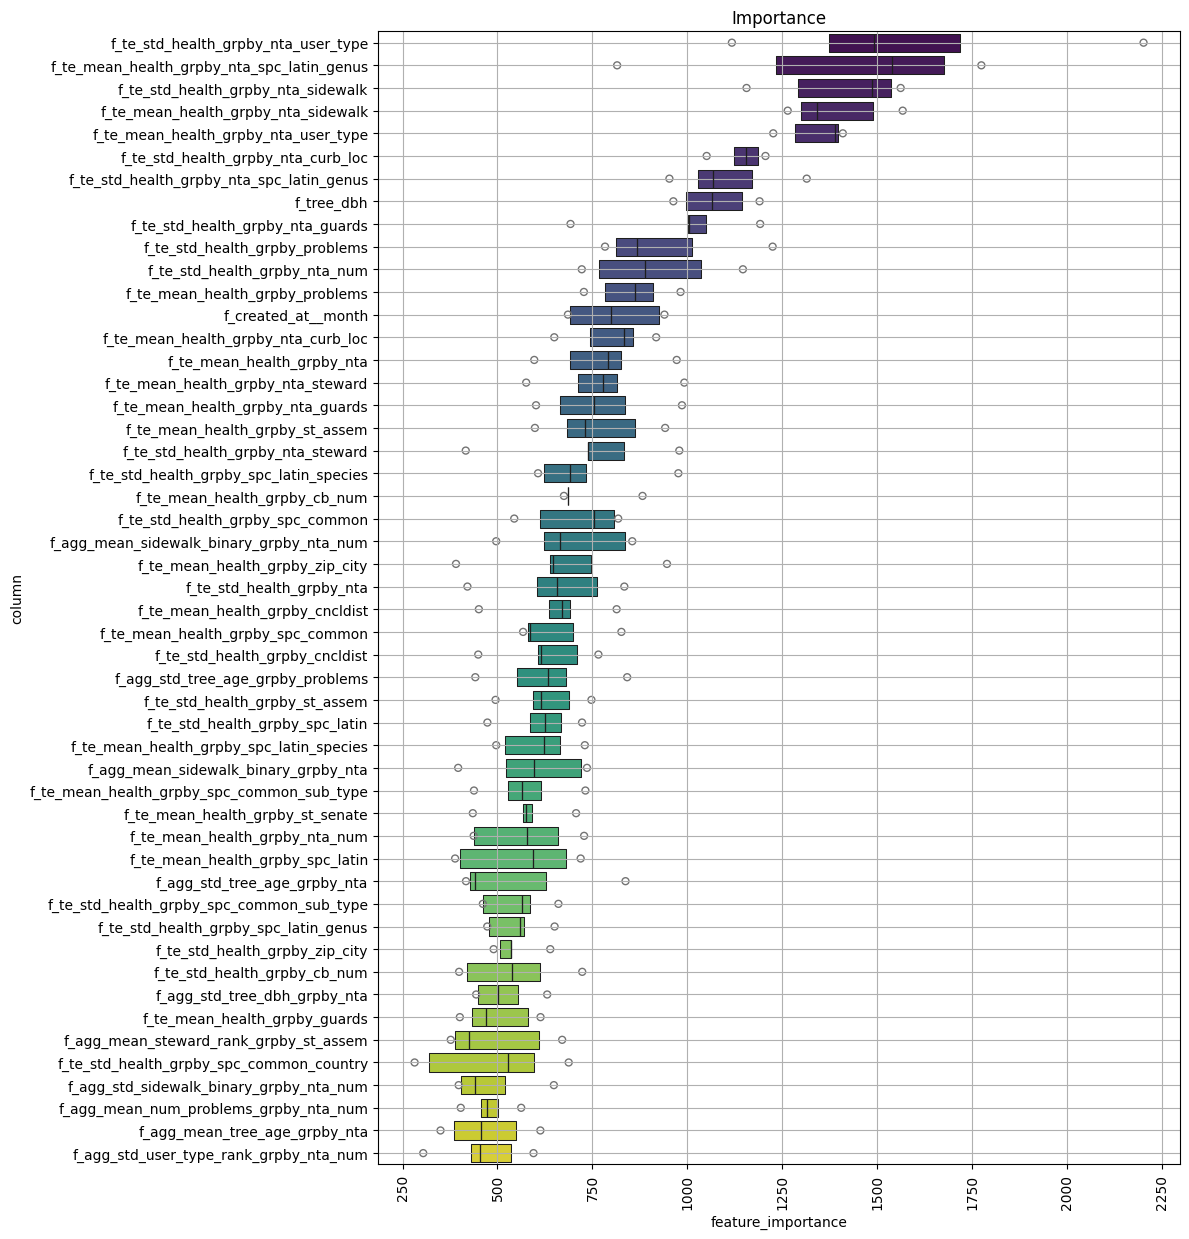

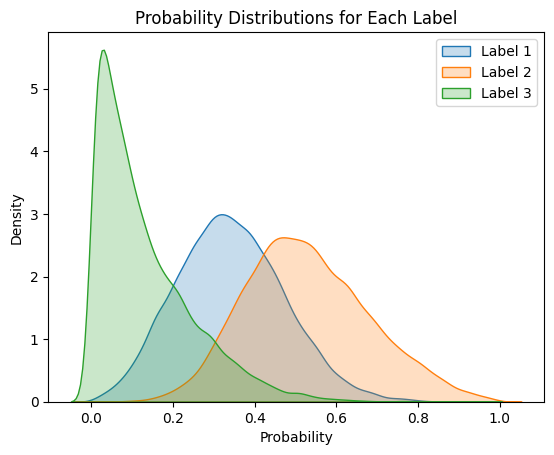

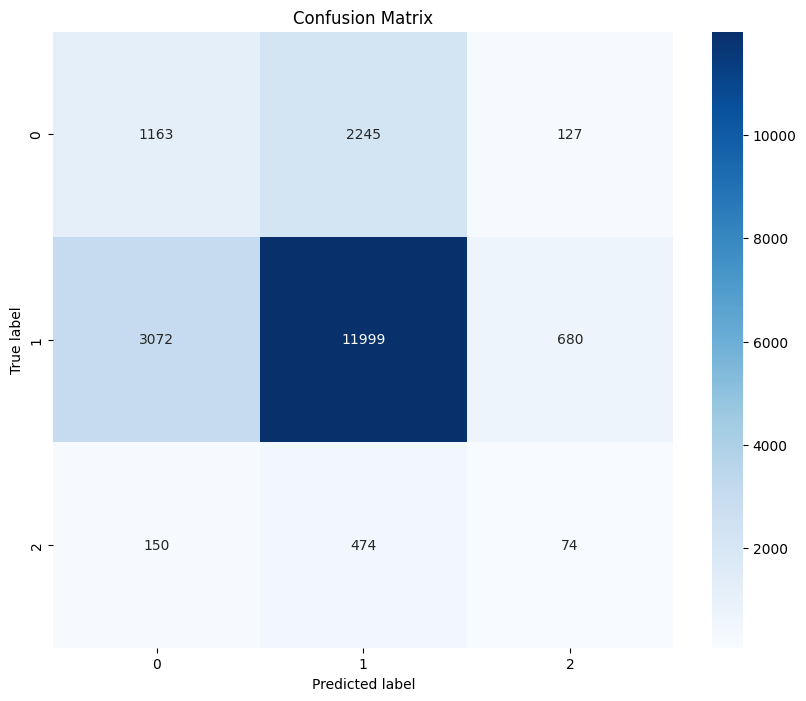

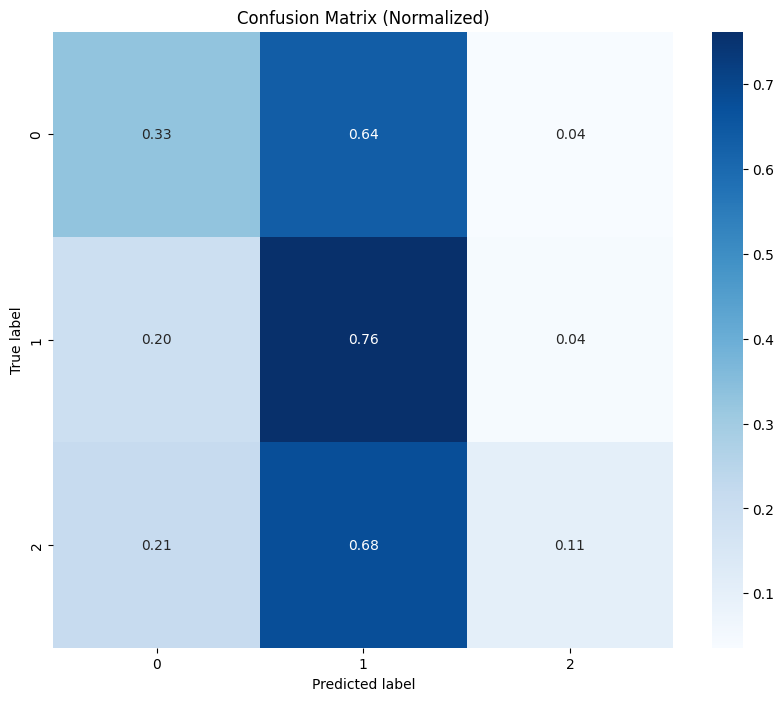

In [8]:
fig, importance_df = visualize_feature_importance(
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    top_n=50,
)
fig.savefig(OUTPUT_DIR / "feature_importance.png", dpi=300)
importance_df.to_csv(OUTPUT_DIR / "feature_importance.csv", index=False)


fig = plot_label_distributions(proba_matrix=np.array(valid_result_df["pred"].tolist()))
fig.show()
fig.savefig(OUTPUT_DIR / "label_distributions.png", dpi=300)


fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label)
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label, normalize=True)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [9]:
test_result_df = predict_cv_tabular_v1(
    df=test_feature_df,
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    test=True,
    predict_proba=CFG.model.predict_proba,
)

test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["pred"] = np.argmax(test_pred_df.groupby("uid").mean(), axis=1)
submission_df = test_df[["uid", "pred"]]
submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}.csv"
submission_df.to_csv(submission_filepath, index=False, header=False)

fold0 predict : test=True
fold1 predict : test=True
fold2 predict : test=True
fold3 predict : test=True
fold4 predict : test=True


In [17]:
test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["opt_pred"] = decode_label(proba_matrix=test_pred_df.groupby("uid").mean().to_numpy(), thresholds=opt_results)

submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}_opt_{best_f1_score:.3f}.csv"
test_df[["uid", "opt_pred"]].to_csv(submission_filepath, index=False, header=False)

joblib.dump(test_pred_df, OUTPUT_DIR / "test_result_df.pkl")

['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=018-tabular_v2/test_result_df.pkl']

In [11]:
print(test_df["opt_pred"].value_counts() / len(test_df))

opt_pred
1    0.742361
0    0.211146
2    0.046493
Name: count, dtype: float64


In [12]:
test_df["pred"].value_counts() / len(test_df)

pred
1    0.742463
0    0.211045
2    0.046493
Name: count, dtype: float64

In [13]:
train_df["health"].value_counts() / len(train_df)

health
1    0.788181
0    0.176892
2    0.034928
Name: count, dtype: float64

In [14]:
raw_feature_df

,uid,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,...,f_te_mean_health_grpby_nta_curb_loc,f_te_std_health_grpby_nta_curb_loc,f_te_mean_health_grpby_nta_steward,f_te_std_health_grpby_nta_steward,f_te_mean_health_grpby_nta_guards,f_te_std_health_grpby_nta_guards,f_te_mean_health_grpby_nta_sidewalk,f_te_std_health_grpby_nta_sidewalk,f_te_mean_health_grpby_nta_user_type,f_te_std_health_grpby_nta_user_type
0,0,2015-06-29,14,OnCurb,1.0,NaN,NaN,Damage,Volunteer,NaN,...,0.895349,0.484353,NaN,NaN,NaN,NaN,0.947917,0.467238,0.900901,0.485329
1,1,2016-09-21,5,OnCurb,1.0,3or4,Helpful,NoDamage,Volunteer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2015-09-13,26,OnCurb,2.0,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,...,0.826923,0.470221,NaN,NaN,NaN,NaN,0.886792,0.464363,0.798507,0.455210
3,3,2016-05-09,15,OnCurb,0.0,NaN,NaN,Damage,NYC Parks Staff,NaN,...,0.898438,0.421758,NaN,NaN,NaN,NaN,0.846154,0.478047,0.932203,0.486522
4,4,2016-06-24,23,OnCurb,1.0,NaN,NaN,NoDamage,Volunteer,Stones,...,0.754098,0.505165,NaN,NaN,NaN,NaN,0.783784,0.417342,0.741935,0.444803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39681,39964,2015-09-10,3,OnCurb,NaN,1or2,Harmful,Damage,Volunteer,StonesRootOther,...,0.877049,0.437458,0.843750,0.447889,1.0,0.0,0.875000,0.442066,0.876712,0.439229
39682,39965,2016-09-09,9,OnCurb,NaN,1or2,NaN,NoDamage,NYC Parks Staff,NaN,...,0.851852,0.428316,0.958333,0.204124,NaN,NaN,0.857143,0.408248,0.882353,0.485071
39683,39966,2015-12-31,16,OnCurb,NaN,NaN,NaN,Damage,Volunteer,NaN,...,0.881579,0.431033,NaN,NaN,NaN,NaN,0.861111,0.424451,0.884615,0.378534
39684,39967,2016-09-07,24,OnCurb,NaN,NaN,NaN,Damage,TreesCount Staff,RootOtherTrunkOtherBranchOther,...,0.867257,0.433104,NaN,NaN,NaN,NaN,0.833333,0.489732,0.973684,0.162221


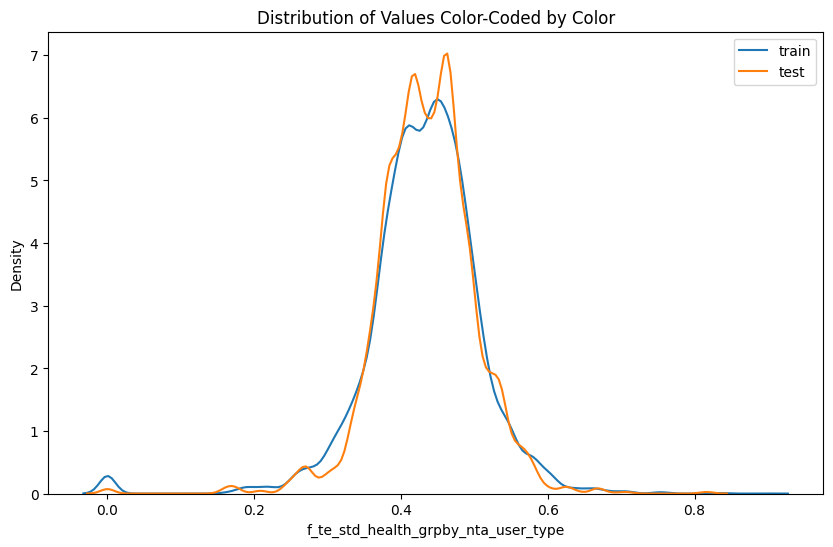

In [16]:
def plot_dist_by_color(df, value_col, color_col):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    for color in df[color_col].unique():
        sns.distplot(df[value_col][df[color_col] == color], hist=False, label=color)

    plt.title("Distribution of Values Color-Coded by Color")
    plt.legend()
    plt.show()


plot_dist_by_color(df=raw_feature_df, value_col="f_te_std_health_grpby_nta_user_type", color_col="data")